# MURA project deep learning

### Updates - 04/23/2019
1. Selected on ELBOW for training our models.
2. Models(pre-built) are now training w/o errors.
3. Need to fix issue of stagnant train acc,loss and volatile valid acc,loss by shuffling train and valid lists.

### Updates - 04/20/2019
1. Reshaping the images to be of size 512x512 which is the size used in most of the MURA implementaions on github.
2. Reshaping is done by black padding the images so that the original image stays in the center.

Dataset and competition page - https://stanfordmlgroup.github.io/competitions/mura/

In [0]:
# Import necessary libraries

# Numerical computation
import numpy as np

# Data manipulation
import pandas as pd

# Deep Learning libraries
import tensorflow as tf
from tensorflow.python import keras

# Data Viz
import matplotlib.pyplot as plt
%matplotlib inline

# Operating system lib
import os

In [0]:
# Download the MURA dataset
# Reference -
from urllib.request import urlretrieve
from zipfile import ZipFile

def download(url, file):
    if not os.path.isfile(file):
        print("Download file... " + file + " ...")
        urlretrieve(url,file)
        print("File downloaded")

download('https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip','MURA.zip')
print("All the files are downloaded")

All the files are downloaded


In [0]:
# Unzip the file
!unzip MURA.zip

Archive:  MURA.zip
replace MURA-v1.1/train_labeled_studies.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
N


In [0]:
# Change working directory and display the files and folders within the MURA-v1.1 directory
os.chdir('MURA-v1.1')
os.listdir()

['train',
 'valid_image_paths.csv',
 'train_image_paths.csv',
 'train_labeled_studies.csv',
 'valid_labeled_studies.csv',
 'valid']

In [0]:
# Load the csv file as a pandas df containing the training image paths
train_image_paths = pd.read_csv('train_image_paths.csv',header=None)
train_image_paths.columns = ['image_path']
train_image_paths.head(5)

# Load the csv file as a pandas df containing the validation image paths
valid_image_paths = pd.read_csv('valid_image_paths.csv',header=None)
valid_image_paths.columns = ['image_path']
valid_image_paths.head(5)

,image_path
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...


In [0]:
# Load the csv file as a pandas df containing the training study labels
train_labelled_studies = pd.read_csv('train_labeled_studies.csv',header=None)
train_labelled_studies.columns = ['study_name','label']
train_labelled_studies.head(5)

# Load the csv file as a pandas df containing the validation study labels
valid_labelled_studies = pd.read_csv('valid_labeled_studies.csv',header=None)
valid_labelled_studies.columns = ['study_name','label']
valid_labelled_studies.head(5)

,study_name,label
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
1,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1
2,MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...,1
3,MURA-v1.1/valid/XR_WRIST/patient11186/study3_p...,1
4,MURA-v1.1/valid/XR_WRIST/patient11187/study1_p...,1


In [0]:
# Go back one directory to the parent
os.chdir('..')

In [0]:

def addImageLists(df):
  """
  Function which takes a studies dataframe (train or valid) and returns the dataframe after adding a new column containing lists of images in that study
  """
  # Our column containing a list of images for each study
  images = []

  for study_name in df['study_name']:
    image_list = [study_name+image_name for image_name in os.listdir(study_name)]
    images.append(image_list)
    
  # Add the column and return the dataframe
  df['images'] = images
  return df
  

In [0]:
# Create the new train_labelled_studies df for EDA
train_labelled_studies = addImageLists(train_labelled_studies)
# Create the new valid_labelled_studies df for EDA
valid_labelled_studies = addImageLists(valid_labelled_studies)

In [0]:
# Filter data relevant only to a particular body part
# MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/

BODY_PART = 'XR_ELBOW'

# Filter the train dataframe for a particular body part
train_labelled_studies = train_labelled_studies[train_labelled_studies['study_name'].str.contains(BODY_PART)]

# Filter the valid dataframe for a particular body part
valid_labelled_studies = valid_labelled_studies[valid_labelled_studies['study_name'].str.contains(BODY_PART)]

In [0]:
def createImageLists(df):
  """
  Function which takes a studies dataframe (train or valid) and returns the dataframe after adding a new column containing lists of images in that study
  """
  # Our column containing a list of images for each study
  images = []
  labels = []
  
  for index, row in df.iterrows():
    
    study_name = row['study_name']
    label = row['label']
    
    for image_name in os.listdir(study_name):
      images.append(study_name+image_name)
      labels.append(label)
    
  return images,labels

In [0]:
# Generate the train image and label lists
train_image_list, train_label_list = createImageLists(train_labelled_studies)

# Generate the validation image and label lists
valid_image_list, valid_label_list = createImageLists(valid_labelled_studies)

In [0]:
# Start an interactive tf session
sess = tf.InteractiveSession()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### Load VGG16 model

In [0]:
#Try loading our models
from keras.models import model_from_json
from keras import optimizers

# load json and create model
json_file = open('VGG16_model_finetuned_extra_architecture.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model1 = model_from_json(loaded_model_json)
# load weights into new model
loaded_model1.load_weights("VGG16_model_extra_weights.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model1.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(lr=1e-7),metrics=['acc'])

Instructions for updating:
Colocations handled automatically by placer.
Loaded model from disk


### Load Inception model

In [0]:
from keras.models import load_model

loaded_model2 = load_model("best_model_dropout (4).h5")

### Load VGG19 model

In [0]:
from keras.models import load_model

loaded_model3 = load_model("VGG19_no_freeze_do2_acc1.h5")

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


## Loaded our best models successfully

## Now get studywise predictions

Each study can have 1 or more images, To get studywise predictions we predict the class(0/1) of each image of the study and then the final study predcition is the arithmetic mean of the the predictions(sigmoid) of the study images using a threshold value of 0.5 to determine whether the study is classified as 0(normal) or 1(abnormal).

In [0]:
# Studywise predictions
valid_labelled_studies.head(5)

,study_name,label,images
866,MURA-v1.1/valid/XR_ELBOW/patient11659/study1_p...,1,[MURA-v1.1/valid/XR_ELBOW/patient11659/study1_...
867,MURA-v1.1/valid/XR_ELBOW/patient11802/study1_p...,1,[MURA-v1.1/valid/XR_ELBOW/patient11802/study1_...
868,MURA-v1.1/valid/XR_ELBOW/patient11803/study1_p...,1,[MURA-v1.1/valid/XR_ELBOW/patient11803/study1_...
869,MURA-v1.1/valid/XR_ELBOW/patient11804/study1_p...,1,[MURA-v1.1/valid/XR_ELBOW/patient11804/study1_...
870,MURA-v1.1/valid/XR_ELBOW/patient11805/study1_p...,1,[MURA-v1.1/valid/XR_ELBOW/patient11805/study1_...


## Get predictions for VGG16

In [0]:
# Studywise predictions
studywise_predictions_binary_vgg16 = []
studywise_predictions = []

test_counter = 0

for indx,study_row in valid_labelled_studies.iterrows():
  print('Study:\n',study_row['study_name'])
  
  # List of images for the study
  study_image_list = study_row['images']
  
  # List to store the predictions for each image
  study_predictions = []
  
  # Number of study images
  num_study_imgs = len(study_image_list)
  
  for study_image in study_image_list:
    # Read the image from disk
    image_string = tf.read_file(study_image)
    # Decode the image
    image = tf.image.decode_png(image_string,channels=3)
    # Resize into 512x512 images
    image_vgg = tf.image.resize_image_with_crop_or_pad(image,512,512)
    # Plot the image
    image_vgg = sess.run(image_vgg)
    # plt.imshow(image)
    # plt.title(study_image[-10:])
    # plt.show()
    # Make the predictions
    image_vgg = np.reshape(image_vgg,newshape=[1,512,512,3])
    pred = loaded_model1.predict(image_vgg)
    study_predictions.append(pred)
    
  # Take the average of all predictions as the study prediction
  avg_prediction = sum(study_predictions)/num_study_imgs
  
  # Sigmoid values
  studywise_predictions.append(avg_prediction)
    
  # Class predictions 0/1
  if avg_prediction < 0.5:
    studywise_predictions_binary_vgg16.append(0)
  else:
    studywise_predictions_binary_vgg16.append(1)
  
#   test_counter+=1
  
#   if test_counter==5:
#     break

Study:
 MURA-v1.1/valid/XR_ELBOW/patient11659/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11802/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11803/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11804/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11805/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11414/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11186/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11806/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11807/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11793/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11358/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11417/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11417/study2_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11586/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11389/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11808/study1_po

In [0]:
# Get the study classification report
from sklearn.metrics import classification_report
print(classification_report(studywise_predictions_binary_vgg16,valid_labelled_studies['label'].tolist()),)

              precision    recall  f1-score   support

           0       0.95      0.84      0.89       103
           1       0.76      0.91      0.83        55

   micro avg       0.87      0.87      0.87       158
   macro avg       0.85      0.88      0.86       158
weighted avg       0.88      0.87      0.87       158



In [0]:
# Getting the sigmoid values in proper format
stdy_predictions = []

for i in range(len(studywise_predictions)):
  stdy_predictions.append(studywise_predictions[i][0][0])

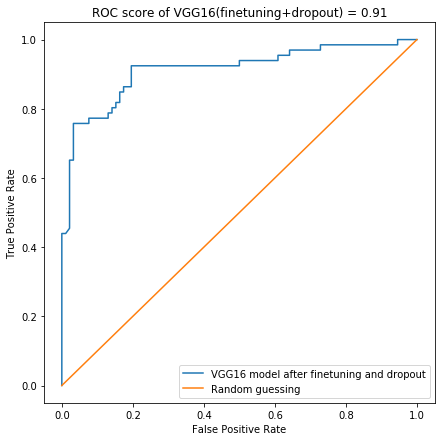

In [0]:
# Plot ROC curve
plt.rcParams["figure.figsize"] = (7,7)
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(valid_labelled_studies['label'].tolist(),stdy_predictions)
auc_score = roc_auc_score(valid_labelled_studies['label'].tolist(),stdy_predictions)

plt.plot(fpr,tpr,label='VGG16 model after finetuning and dropout')
plt.plot(fpr,fpr,label='Random guessing')
plt.title('ROC score of VGG16(finetuning+dropout) = %2.2f'%auc_score)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

In [0]:
# Try to calculate Cohen's Kappa score
# In practice we need to compute this score on studies instead of individual images
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(studywise_predictions_binary_vgg16,valid_labelled_studies['label'].tolist())

0.7201889020070837

## Get predictions for VGG19

In [0]:
# Studywise predictions
studywise_predictions_binary_vgg19 = []
studywise_predictions = []

test_counter = 0

for indx,study_row in valid_labelled_studies.iterrows():
  print('Study:\n',study_row['study_name'])
  
  # List of images for the study
  study_image_list = study_row['images']
  
  # List to store the predictions for each image
  study_predictions = []
  
  # Number of study images
  num_study_imgs = len(study_image_list)
  
  for study_image in study_image_list:
    # Read the image from disk
    image_string = tf.read_file(study_image)
    # Decode the image
    image = tf.image.decode_png(image_string,channels=3)
    # Resize into 512x512 images
    image_vgg = tf.image.resize_image_with_crop_or_pad(image,512,512)
    # Plot the image
    image_vgg = sess.run(image_vgg)
    # plt.imshow(image)
    # plt.title(study_image[-10:])
    # plt.show()
    # Make the predictions
    image_vgg = np.reshape(image_vgg,newshape=[1,512,512,3])
    pred = loaded_model3.predict(image_vgg)
    study_predictions.append(pred)
    
  # Take the average of all predictions as the study prediction
  avg_prediction = sum(study_predictions)/num_study_imgs
  
  # Sigmoid values
  studywise_predictions.append(avg_prediction)
    
  # Class predictions 0/1
  if avg_prediction < 0.5:
    studywise_predictions_binary_vgg19.append(0)
  else:
    studywise_predictions_binary_vgg19.append(1)
  
#   test_counter+=1
  
#   if test_counter==5:
#     break

Study:
 MURA-v1.1/valid/XR_ELBOW/patient11659/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11802/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11803/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11804/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11805/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11414/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11186/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11806/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11807/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11793/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11358/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11417/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11417/study2_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11586/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11389/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11808/study1_po

In [0]:
# Get the study classification report
from sklearn.metrics import classification_report
print(classification_report(studywise_predictions_binary_vgg19,valid_labelled_studies['label'].tolist()),)

              precision    recall  f1-score   support

           0       0.95      0.81      0.87       107
           1       0.70      0.90      0.79        51

   micro avg       0.84      0.84      0.84       158
   macro avg       0.82      0.86      0.83       158
weighted avg       0.87      0.84      0.85       158



In [0]:
# Getting the sigmoid values in proper format
stdy_predictions = []

for i in range(len(studywise_predictions)):
  stdy_predictions.append(studywise_predictions[i][0][0])

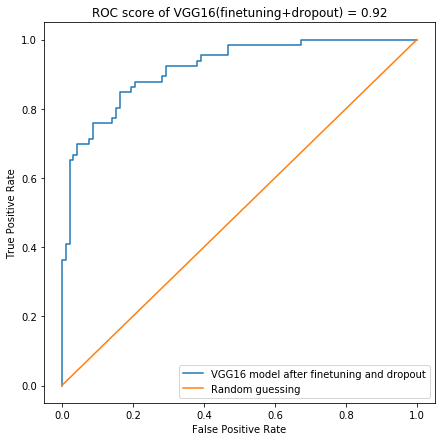

In [0]:
# Plot ROC curve
plt.rcParams["figure.figsize"] = (7,7)
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(valid_labelled_studies['label'].tolist(),stdy_predictions)
auc_score = roc_auc_score(valid_labelled_studies['label'].tolist(),stdy_predictions)

plt.plot(fpr,tpr,label='VGG16 model after finetuning and dropout')
plt.plot(fpr,fpr,label='Random guessing')
plt.title('ROC score of VGG16(finetuning+dropout) = %2.2f'%auc_score)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

In [0]:
# Try to calculate Cohen's Kappa score
# In practice we need to compute this score on studies instead of individual images
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(studywise_predictions_binary_vgg19,valid_labelled_studies['label'].tolist())

0.6639441892121831

## Getting results for inception model

In [0]:
# Studywise predictions
studywise_predictions_binary_inception = []
studywise_predictions = []

test_counter = 0

for indx,study_row in valid_labelled_studies.iterrows():
  print('Study:\n',study_row['study_name'])
  
  # List of images for the study
  study_image_list = study_row['images']
  
  # List to store the predictions for each image
  study_predictions = []
  
  # Number of study images
  num_study_imgs = len(study_image_list)
  
  for study_image in study_image_list:
    # Read the image from disk
    image_string = tf.read_file(study_image)
    # Decode the image
    image = tf.image.decode_png(image_string,channels=3)
    # Resize into 512x512 images
    image_vgg = tf.image.resize_image_with_crop_or_pad(image,420,420)
    # Plot the image
    image_vgg = sess.run(image_vgg)
    # plt.imshow(image)
    # plt.title(study_image[-10:])
    # plt.show()
    # Make the predictions
    image_vgg = np.reshape(image_vgg,newshape=[1,420,420,3])
    pred = loaded_model2.predict(image_vgg)
    study_predictions.append(pred)
    
  # Take the average of all predictions as the study prediction
  avg_prediction = sum(study_predictions)/num_study_imgs
  
  # Sigmoid values
  studywise_predictions.append(avg_prediction)
    
  # Class predictions 0/1
  if avg_prediction < 0.5:
    studywise_predictions_binary_inception.append(0)
  else:
    studywise_predictions_binary_inception.append(1)
  
#   test_counter+=1
  
#   if test_counter==5:
#     break

Study:
 MURA-v1.1/valid/XR_ELBOW/patient11659/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11802/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11803/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11804/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11805/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11414/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11186/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11806/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11807/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11793/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11358/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11417/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11417/study2_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11586/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11389/study1_positive/
Study:
 MURA-v1.1/valid/XR_ELBOW/patient11808/study1_po

In [0]:
# Get the study classification report
from sklearn.metrics import classification_report
print(classification_report(studywise_predictions_binary_inception,valid_labelled_studies['label'].tolist()),)

              precision    recall  f1-score   support

           0       0.96      0.79      0.87       111
           1       0.65      0.91      0.76        47

   micro avg       0.83      0.83      0.83       158
   macro avg       0.80      0.85      0.81       158
weighted avg       0.87      0.83      0.84       158



In [0]:
# Getting the sigmoid values in proper format
stdy_predictions = []

for i in range(len(studywise_predictions)):
  stdy_predictions.append(studywise_predictions[i][0][0])

In [0]:
# Plot ROC curve
plt.rcParams["figure.figsize"] = (7,7)
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(valid_labelled_studies['label'].tolist(),stdy_predictions)
auc_score = roc_auc_score(valid_labelled_studies['label'].tolist(),stdy_predictions)

plt.plot(fpr,tpr,label='VGG16 model after finetuning and dropout')
plt.plot(fpr,fpr,label='Random guessing')
plt.title('ROC score of VGG16(finetuning+dropout) = %2.2f'%auc_score)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

NameError: ignored

In [0]:
# Try to calculate Cohen's Kappa score
# In practice we need to compute this score on studies instead of individual images
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(studywise_predictions_binary_inception,valid_labelled_studies['label'].tolist())

0.6338197424892704

## Ensembling

In [0]:
def voting(p1,p2,p3):
  p = []
  for i in range(len(p1)):
    res = 0.72*p1[i] + 0.66*p2[i] + 0.63*p3[i]
    if res < 1.3:
      p.append(0)
    else:
      p.append(1)
  return p
      
predictions_binary_ensemble = voting(studywise_predictions_binary_vgg16,studywise_predictions_binary_vgg19,studywise_predictions_binary_inception)

In [0]:
# Get the study classification report
from sklearn.metrics import classification_report
print(classification_report(predictions_binary_ensemble,valid_labelled_studies['label'].tolist()))

              precision    recall  f1-score   support

           0       0.97      0.82      0.89       108
           1       0.71      0.94      0.81        50

   micro avg       0.86      0.86      0.86       158
   macro avg       0.84      0.88      0.85       158
weighted avg       0.89      0.86      0.86       158



In [0]:
# Try to calculate Cohen's Kappa score
# In practice we need to compute this score on studies instead of individual images
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(predictions_binary_ensemble,valid_labelled_studies['label'].tolist())

0.7036152796725784